# Report on Autoscaled M/M/c Load-Balanced Cluster with Thresholds and Boot Setup Time

## Problem outline

The cloud cluster autoscaler is a mechanism, that allows to dynamically scale the size of the system, with respect to the number of simultaneous workers. The number of workers depends on the demand and can have various implementations.

In this analysis we deal with one central queue (requests arrive $\text{Poisson}(λ)$), $c$ identical servers ($\text{Exp}(μ)$ service). When the queue is empty, most servers power down, to a pre-defined amount. A powered-down server takes a random setup time ($\text{Exp}(γ)+\text{const}$) to boot. A simple N-policy turns servers on when the queue length crosses thresholds (e.g., bring up 1 server when $Q \geq N_1$, 2 when $Q \geq N_2$, ...).

## Formal approach

For the basic M/M/c system we have:

- $\lambda$ - mean arrival rate
- $\mu$ - mean service rate per server
- $c$ - number of servers
- $\rho = \frac{\lambda}{c\mu}$ - traffic intensity per server
- stationary probabilities $p_n$:
  $$
  p_n =
    \begin{cases}
      \frac{(c \rho)^n}{n!} p_0,    & 0 \leq n < c, \\
      \frac{c^c \rho^n}{c!} p_0,    & n \geq c.
    \end{cases}
  $$
- empty queue probability $p_0$:
  $$
  p_0 = \left(\sum^{c-1}_{n=0}\frac{(c \rho)^n}{n!} + \frac{(c \rho)^c}{c!} \cdot \frac{1}{1-\rho}\right)^{-1}
  $$
- delay probability $\Pi_W$:
  $$
  \Pi_W = \frac{p_c}{1-\rho}
  $$
- mean number of customers waiting in the queue $\bold{E}(L^q)$:
  $$
  \bold{E}(L^q) = \Pi_W \cdot \frac{\rho}{1-\rho}
  $$
- expected waiting time $\bold{E}(W)$:
  $$
  \bold{E}(W) = \Pi_W \cdot \frac{1/c\mu}{1-\rho}
  $$
- probability distribution of waiting time $\bold{P}(W > t)$:
  $$
  \bold{P}(W>t) = \Pi_W e^{-c\mu(1-\rho)t}, t \geq 0
  $$
- probability distribution of sojourn time $\bold{P}(S > t)$:
    $$
  \bold{P}(S > t) =
    \begin{cases}
      \frac{\Pi_W}{1-c(1-\rho)} \left( e^{-c\mu(1-\rho)t} - e^{- \mu t} \right) + e^{- \mu t},    & t \geq 0, c(1-\rho) \neq 1, \\
      (\mu \Pi_W t + 1)e^{- \mu t},                                                               & t \geq 0, c(1-\rho) = 1.
    \end{cases}
  $$

Additionally for the non-zero setup systems one must consider:

- $\theta$ - mean setup rate of a server

### Numerical calculations

#### Assumed values

- $\lambda = 1.0$
- $\mu = 1.0$
- $\theta = 1.0$
- $c \in [1, 10]$
- $N = 4$ - the queue size for which new server is started

In [23]:
LAMBDA = 1.0          # arrival rate
MU = 1.0              # service rate
THETA = 1.0           # setup rate
C_MIN = 1             # minimum number of servers
C_MAX = 10            # maximum number of servers
N = 4                 # queue threshold for turning on a new server

#### (Imports)

In [138]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import product
from math import factorial
from tqdm import tqdm

#### Traffic intensity $\rho$

In [25]:
rho = LAMBDA / MU / C_MAX
print(f"Mean traffic intensity per server (rho): {rho:.3f}")

Mean traffic intensity per server (rho): 0.100


##### Stability analysis

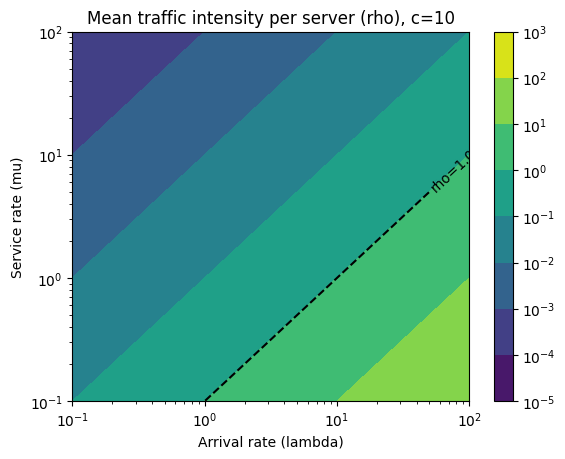

In [ ]:
#| width: 10%
lambda_range = np.logspace(start=-1, stop=2, num=100, base=10)
mu_range = np.logspace(start=-1, stop=2, num=100, base=10)

lambda_mesh, mu_mesh = np.meshgrid(lambda_range, mu_range)
rho_matrix = lambda_mesh / mu_mesh / C_MAX

plt.contourf(lambda_mesh, mu_mesh, rho_matrix, norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Arrival rate (lambda)")
plt.ylabel("Service rate (mu)")
plt.title(f"Mean traffic intensity per server (rho), c={C_MAX}")

contour = plt.contour(lambda_mesh, mu_mesh, rho_matrix, levels=[1.0], colors="k", linestyles="dashed")
plt.clabel(contour, fmt={1.0: "rho=1.0"})
plt.show()


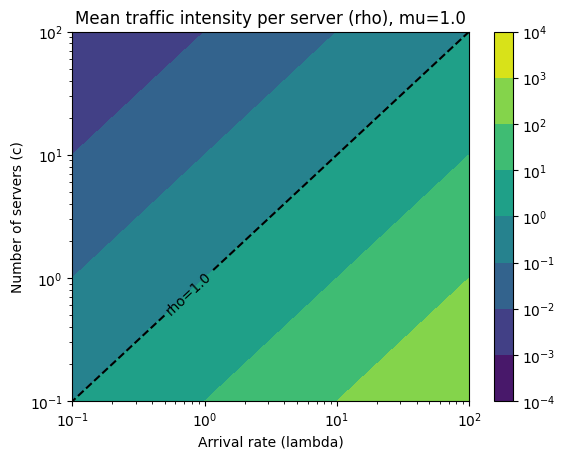

In [27]:
lambda_range = np.logspace(start=-1, stop=2, num=100, base=10)
c_range = np.logspace(start=-1, stop=2, num=100, base=10)

lambda_mesh, c_mesh = np.meshgrid(lambda_range, c_range)
rho_matrix = lambda_mesh / MU / c_mesh

plt.contourf(lambda_mesh, c_mesh, rho_matrix, norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Arrival rate (lambda)")
plt.ylabel("Number of servers (c)")
plt.title("Mean traffic intensity per server (rho), mu=1.0")

contour = plt.contour(lambda_mesh, c_mesh, rho_matrix, levels=[1.0], colors="k", linestyles="dashed")
plt.clabel(contour, fmt={1.0: "rho=1.0"})
plt.show()

#### Probability of 0 customers $p_0$

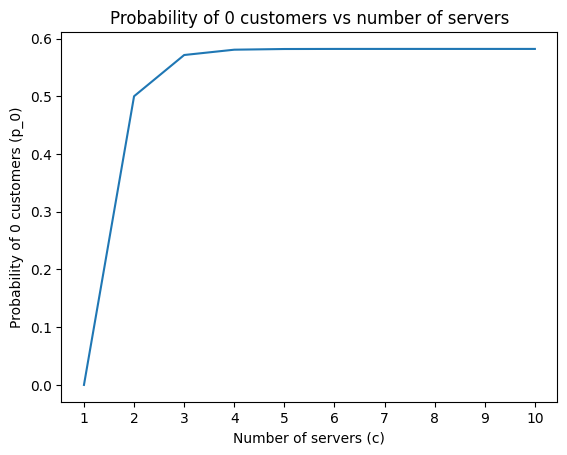

In [28]:
def p_0(c):
    rho = LAMBDA / MU / c

    p_0_inverse = (c * rho) ** c / (factorial(c) * (1 - rho+1e-10))  # Adding a small value to avoid division by zero

    for n in range(C_MIN, c):
        p_0_inverse += (c * rho) ** n / factorial(n)

    return p_0_inverse ** -1

c_range = range(1, 11)
plt.plot(c_range, [p_0(c) for c in c_range])
plt.xlabel("Number of servers (c)")
plt.ylabel("Probability of 0 customers (p_0)")
plt.title("Probability of 0 customers vs number of servers")
plt.xticks(c_range)
plt.show()

In [29]:
print(f"Probability of 0 customers (p_0) for c={C_MAX}: {p_0(C_MAX):.3f}")

Probability of 0 customers (p_0) for c=10: 0.582


#### Probability of all servers busy $p_c$

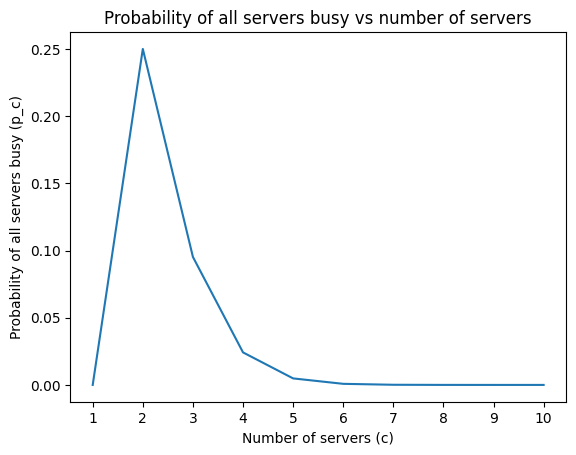

In [30]:
def p_c(c):
    rho = LAMBDA / MU / c
    return (c ** c * rho ** c) / factorial(c) * p_0(c)

c_range = range(1, 11)
plt.plot(c_range, [p_c(c) for c in c_range])
plt.xlabel("Number of servers (c)")
plt.ylabel("Probability of all servers busy (p_c)")
plt.title("Probability of all servers busy vs number of servers")
plt.xticks(c_range)
plt.show()

In [31]:
print(f"Probability of all servers busy (p_c) for c=10: {p_c(C_MAX):.3e}")

Probability of all servers busy (p_c) for c=10: 1.604e-07


#### Probability of delay $\Pi_W$

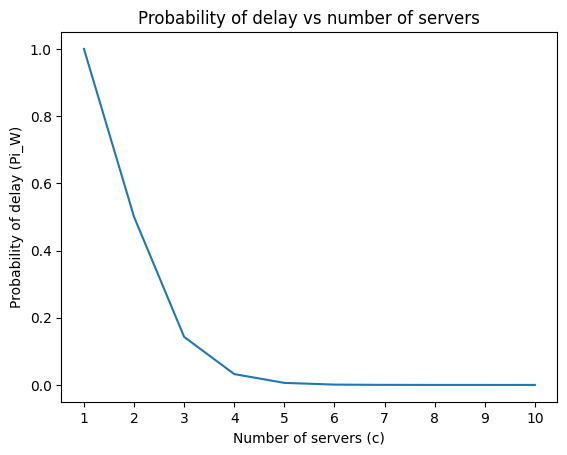

In [32]:
def Pi_W(c):
    rho = LAMBDA / MU / c
    return p_c(c) / (1 - rho+1e-10)  # Adding a small value to avoid division by zero
    
c_range = range(1, 11)
plt.plot(c_range, [Pi_W(c) for c in c_range])
plt.xlabel("Number of servers (c)")
plt.ylabel("Probability of delay (Pi_W)")
plt.title("Probability of delay vs number of servers")
plt.xticks(c_range)
plt.show()

In [33]:
print(f"Probability of delay (Pi_W) for c={C_MAX}: {Pi_W(C_MAX):.3e}")

Probability of delay (Pi_W) for c=10: 1.782e-07


#### Expected length of the queue $\bold{E}(L^q)$

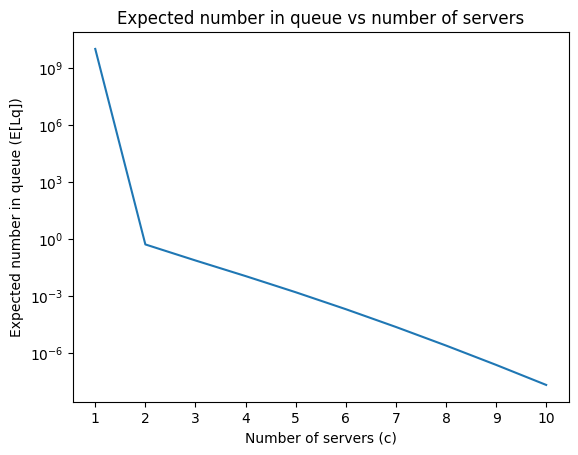

In [34]:
def E_Lq(c):
    rho = LAMBDA / MU / c
    return Pi_W(c) * rho / (1 - rho+1e-10)  # Adding a small value to avoid division by zero

c_range = range(1, 11)
plt.plot(c_range, [E_Lq(c) for c in c_range])
plt.xlabel("Number of servers (c)")
plt.ylabel("Expected number in queue (E[Lq])")
plt.title("Expected number in queue vs number of servers")
plt.xticks(c_range)
plt.yscale("log")
plt.show()

In [35]:
print(f"Expected number in queue (E[Lq]) for c={C_MAX}: {E_Lq(C_MAX):.3e}")

Expected number in queue (E[Lq]) for c=10: 1.980e-08


#### Expected waiting time in queue $\bold{E}(W)$

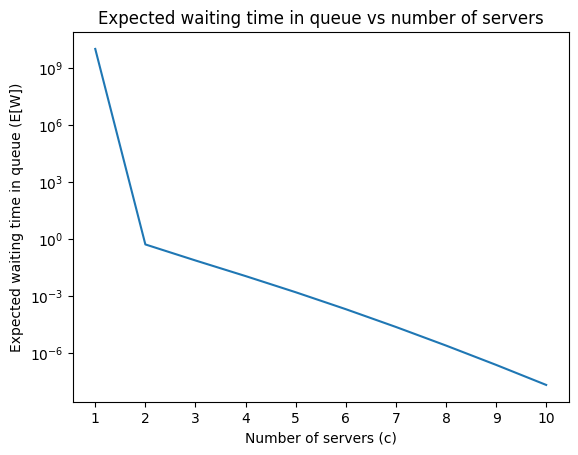

In [36]:
def E_W(c):
    rho = LAMBDA / MU / c
    return Pi_W(c) * ((c * MU) ** -1 / (1 - rho+1e-10))  # Adding a small value to avoid division by zero

c_range = range(1, 11)
plt.plot(c_range, [E_W(c) for c in c_range])
plt.xlabel("Number of servers (c)")
plt.ylabel("Expected waiting time in queue (E[W])")
plt.title("Expected waiting time in queue vs number of servers")
plt.xticks(c_range)
plt.yscale("log")
plt.show()

In [37]:
print(f"Expected waiting time in queue (E[W]) for c={C_MAX}: {E_W(C_MAX):.3e}")

Expected waiting time in queue (E[W]) for c=10: 1.980e-08


#### Probability of waiting more than t $\bold{P}(W > t)$

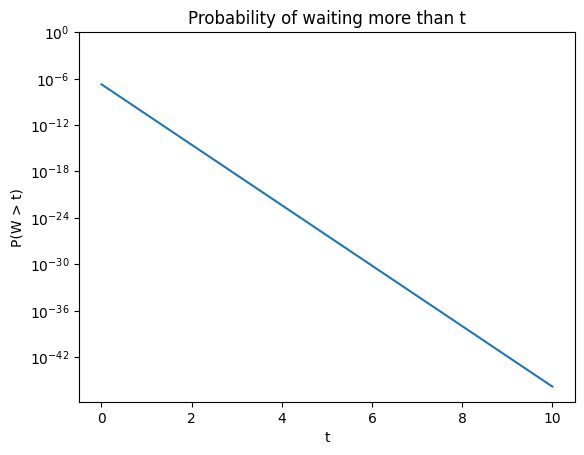

In [38]:
def P_W(t, c=C_MAX):
    rho = LAMBDA / MU / c
    return Pi_W(c) * np.exp(-c * MU * (1-rho) * t)

t_range = np.linspace(start=0, stop=10, num=100)
plt.plot(t_range, P_W(t_range))
plt.title("Probability of waiting more than t")
plt.xlabel("t")
plt.ylabel("P(W > t)")
plt.yscale("log")
plt.ylim(top=1.0)
plt.show()

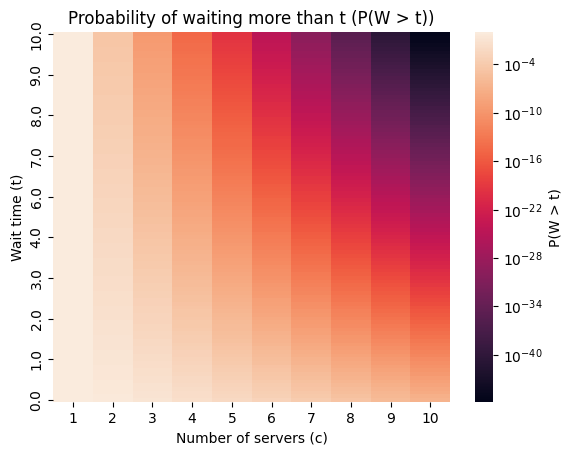

In [39]:
c_range = range(1, 11)

t_mesh, c_mesh = np.meshgrid(t_range, c_range)
P_W_matrix = np.vectorize(P_W)(t_mesh, c_mesh)
P_W_df = pd.DataFrame(P_W_matrix, index=list(c_range), columns=np.round(t_range, 0))

ax = sns.heatmap(P_W_df.T, norm=matplotlib.colors.LogNorm(), cbar_kws={"label": "P(W > t)"},  yticklabels=11, vmax=1.0)
ax.invert_yaxis()
plt.xlabel("Number of servers (c)")
plt.ylabel("Wait time (t)")
plt.title("Probability of waiting more than t (P(W > t))")
plt.show()

In [40]:
P_W_matrix.max()  # sanity check

np.float64(1.0)

##### Conclusion

From the $t$ vs $c$ plot it is clearly visible that with the increase of number of servers the chance of waiting longer decreases.

#### Probability of sojourn time longer than t $\bold{P}(S > t)$

9.0


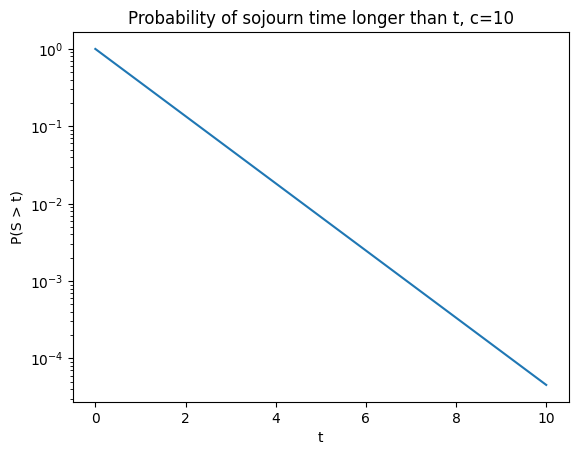

In [41]:
def P_S(t, c=C_MAX):
    if c * (1-rho) == 1:
        return ( MU*Pi_W(c)*t + 1) * np.exp(-MU*t)
    else:
        return Pi_W(c) / (1 - c*(1-rho)) * ( np.exp(-c*MU*(1-rho)*t) - np.exp(-MU*t) ) + np.exp(-MU*t)

print(C_MAX * (1-rho))

plt.plot(t_range, P_S(t_range))
plt.title(f"Probability of sojourn time longer than t, c={C_MAX}")
plt.xlabel("t")
plt.ylabel("P(S > t)")
plt.yscale("log")

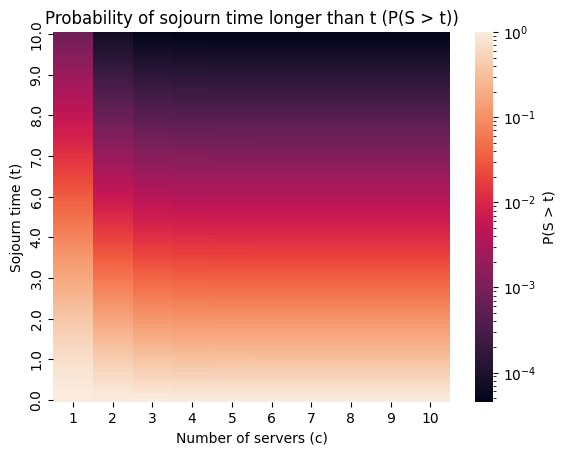

In [42]:
P_S_matrix = np.vectorize(P_S)(t_mesh, c_mesh)
P_S_df = pd.DataFrame(P_S_matrix, index=list(c_range), columns=np.round(t_range, 0))

ax = sns.heatmap(P_S_df.T, norm=matplotlib.colors.LogNorm(), cbar_kws={"label": "P(S > t)"},  yticklabels=11, vmax=1.0)
ax.invert_yaxis()
plt.xlabel("Number of servers (c)")
plt.ylabel("Sojourn time (t)")
plt.title("Probability of sojourn time longer than t (P(S > t))")
plt.show()

##### Conclusion

From the $t$ vs $c$ plot it is visible that for current assumptions, the number of servers $c$ beyond $3$ does not have significant impact on the sojourn time.

## Simulation

The project will include the analytic solution of the M/M/c model, while preparing the numeric simulation of the M/M/c model with automatic scaling and setup time. Later the two will be compared and analyzed for differences in the system response.

In [112]:
np.random.seed(42)
T_MAX = 1000.0         # units
DT = 0.1               # time step resolution
T_SCALE_DOWN = 2.0     # units to wait before scaling down

In [151]:
def simulate(lambda_, theta, mu, t_max, dt, t_scale_down):
    queue_length = 0

    c = C_MIN
    servers = [0] * c  # 0 means idle, >0 means busy, <0 means setting up
    servers_idle_time = [0] * c  # time since server became idle

    queue_lengths = []
    num_servers = []

    for t in np.arange(0, t_max, dt):
        # New arrivals
        arrivals = np.random.poisson(lambda_ * dt)
        queue_length += arrivals

        # Update servers
        for i in range(c):
            if servers[i] > 0:
                # Server is busy
                servers[i] -= dt
                servers_idle_time[i] = 0  # Reset idle time when busy
                if servers[i] <= 0:
                    servers[i] = 0  # Server becomes idle

            elif servers[i] < 0:
                # Server is setting up
                servers[i] += dt
                servers_idle_time[i] = 0  # Reset idle time when setting up
                if servers[i] >= 0:
                    servers[i] = 0  # Server becomes idle
            else:
                # Server is idle
                servers_idle_time[i] += dt

        # Assign jobs to idle servers
        for i in range(c):
            if servers[i] == 0 and queue_length > 0:
                service_time = np.random.exponential(1 / mu)
                servers[i] = service_time
                servers_idle_time[i] = 0  # Reset idle time when job assigned
                queue_length -= 1

        # Scale up if needed
        if queue_length > N and c < C_MAX:
            c += 1
            servers.append(-np.random.exponential(1 / theta))
            servers_idle_time.append(0)  # Track idle time for new server

        # Scale down if possible
        if queue_length == 0 and c > C_MIN:
            idle_servers = [i for i in range(c) if servers_idle_time[i] >= t_scale_down]
            for i in sorted(idle_servers, reverse=True):
                if c == C_MIN:
                    break  # Protect against going below C_MIN
                
                # Remove idle servers from tracking
                servers.pop(i)
                servers_idle_time.pop(i)
                c -= 1

        queue_lengths.append(queue_length)
        num_servers.append(c)

    return np.array(queue_lengths), np.array(num_servers)

In [152]:
queue_lengths, num_servers = simulate(LAMBDA, THETA, MU, T_MAX, DT, T_SCALE_DOWN)

In [153]:
print(f"Average queue length from simulation: {queue_lengths.mean():.3f}")
print(f"Average number of servers from simulation: {num_servers.mean():.3f}")

Average queue length from simulation: 0.896
Average number of servers from simulation: 1.883


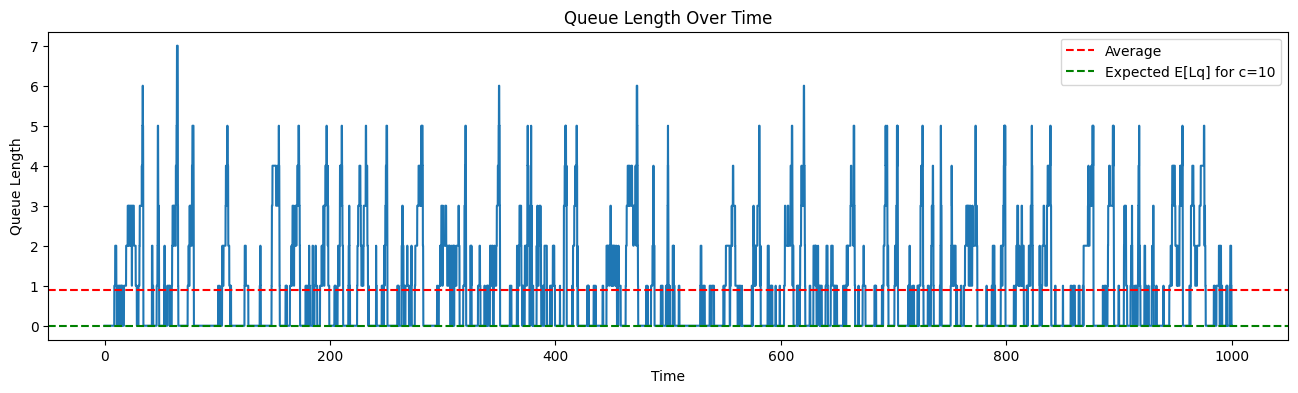

In [154]:
plt.figure(figsize=(16, 4))
plt.plot(np.arange(0, T_MAX, DT), queue_lengths)
plt.axhline(queue_lengths.mean(), color="red", linestyle="--", label="Average")
plt.axhline(E_Lq(C_MAX), color="green", linestyle="--", label=f"Expected E[Lq] for c={C_MAX}")
plt.xlabel("Time")
plt.ylabel("Queue Length")
plt.title("Queue Length Over Time")
plt.legend()
plt.show()

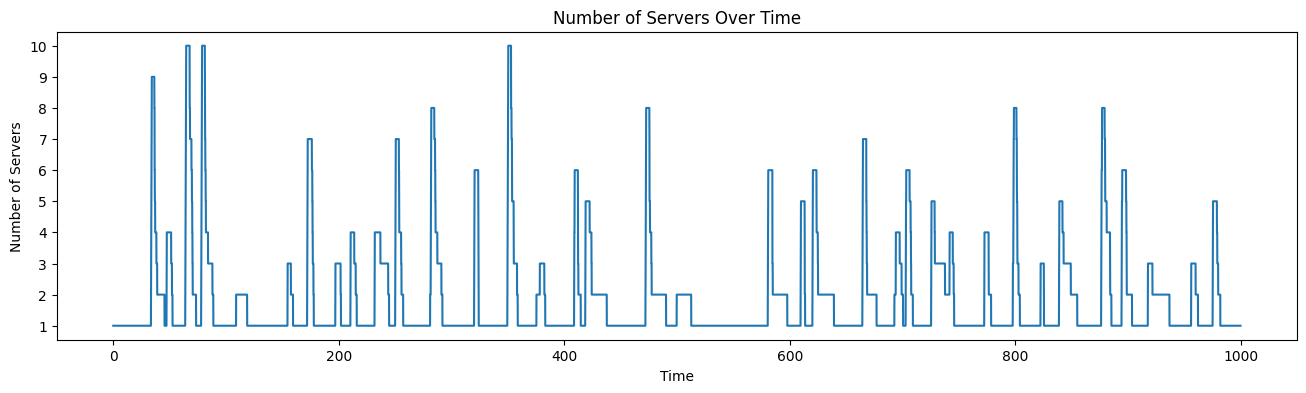

In [155]:
plt.figure(figsize=(16, 4))
plt.plot(np.arange(0, T_MAX, DT), num_servers)
plt.xlabel("Time")
plt.ylabel("Number of Servers")
plt.title("Number of Servers Over Time")
plt.yticks(range(C_MIN, C_MAX + 1))
plt.show()

### Analysis of the setup and scale-down time impact

The simulation will be run for various values of setup rate $\theta$ and scale-down time $t_{scale\_down}$, while keeping other parameters constant.

In [182]:
t_scale_down_range = np.logspace(start=-1, stop=2, num=7, base=10)
theta_range = np.logspace(start=-1, stop=3, num=9, base=10)

queue_lengths = np.zeros((len(t_scale_down_range), len(theta_range)))
num_servers = np.zeros((len(t_scale_down_range), len(theta_range)))

for i_t, i_theta in tqdm(product(range(len(t_scale_down_range)), range(len(theta_range))), total=len(t_scale_down_range)*len(theta_range)):
    t_scale_down = t_scale_down_range[i_t]
    theta = theta_range[i_theta]

    queue_lengths_, num_servers_ = simulate(LAMBDA, theta, MU, T_MAX, DT, t_scale_down)
    queue_lengths[i_t, i_theta] = queue_lengths_.mean()
    num_servers[i_t, i_theta] = num_servers_.mean()

100%|██████████| 63/63 [00:04<00:00, 14.40it/s]


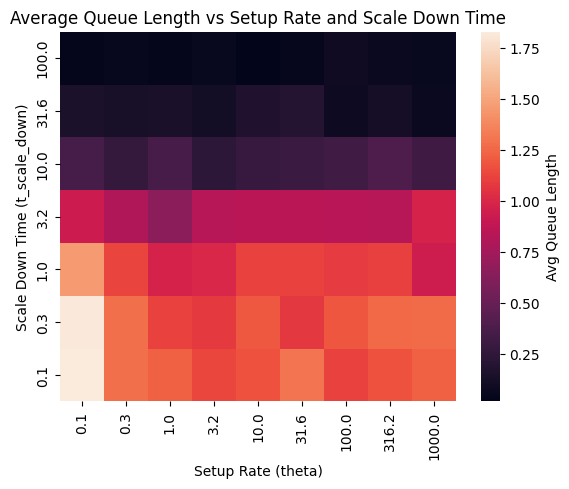

In [ ]:
queue_lengths_df = pd.DataFrame(queue_lengths, index=np.round(t_scale_down_range, 1), columns=np.round(theta_range, 1))
ax = sns.heatmap(queue_lengths_df, cbar_kws={"label": "Avg Queue Length"})
ax.invert_yaxis()
plt.title("Average Queue Length vs Setup Rate and Scale Down Time")
plt.xlabel("Setup Rate (theta)")
plt.xticks(rotation=90)
plt.ylabel("Scale Down Time (t_scale_down)")
plt.show()

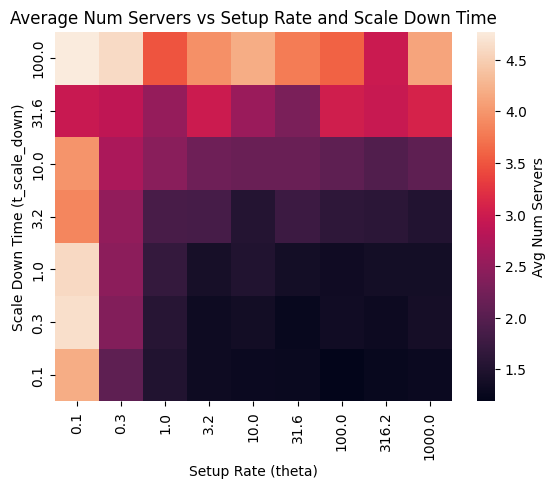

In [190]:
num_servers_df = pd.DataFrame(num_servers, index=np.round(t_scale_down_range, 1), columns=np.round(theta_range, 1))
ax = sns.heatmap(num_servers_df, cbar_kws={"label": "Avg Num Servers"})
ax.invert_yaxis()
plt.title("Average Num Servers vs Setup Rate and Scale Down Time")
plt.xlabel("Setup Rate (theta)")
plt.xticks(rotation=90)
plt.ylabel("Scale Down Time (t_scale_down)")
plt.show()

#### Conclusions

Increasing the scale-down time $t_{scale\_down}$ has a positive impact on the average queue length, resulting in shorter queues as $t_{scale\_down}$ increases. In contrast, the setup rate $\theta$ does not significantly affect the queue length. However, both higher setup rates and longer scale-down times lead to a lower average number of active servers in the system, improving resource efficiency. This demonstrates that tuning these parameters can help balance performance and cost in autoscaled clusters.

## Applications

In this report we analyzed the M/M/c queue with autoscaling and setup time. Given complex assumptions, the system can model very wide range of problems and be found in various real-world applications, including:

- Computer server farms processing web requests,
- Cloud computing clusters autoscaling to handle user requests,
- Call centers with multiple agents handling incoming calls,
- Bank branches with multiple tellers serving customers,
- Fast-food restaurants with multiple cashiers or order windows,
- Hospital emergency rooms with several doctors or nurses serving patients,
- Parking lots with multiple entry/exit gates,
- Airport security checkpoints with several screening lanes,
- Manufacturing assembly lines with parallel workstations.